In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
datapath = 'data/'

In [4]:
campaigns_dd = dd.read_csv(os.path.join(datapath, 'campaigns.csv'))
list(campaigns_dd.columns), campaigns_dd.shape[0].compute()

(['Unnamed: 0', 'customer_id', 'n_offer_days', 'date', 'target_group_flag'],
 500000)

In [5]:
campaigns_dd.describe().compute()

,Unnamed: 0,customer_id,n_offer_days,date,target_group_flag
count,500000.000000,500000.000000,500000.0,500000.0,500000.0
mean,249999.500000,249999.500000,7.0,102.0,1.0
std,144337.711635,144337.711635,0.0,0.0,0.0
min,0.000000,0.000000,7.0,102.0,1.0
25%,124999.750000,124999.750000,7.0,102.0,1.0
50%,249999.500000,249999.500000,7.0,102.0,1.0
75%,374999.250000,374999.250000,7.0,102.0,1.0
max,499999.000000,499999.000000,7.0,102.0,1.0


In [6]:
campaigns_dd['customer_id'].nunique().compute()

500000

Компания была проведена только одна, по 500 тыс. клиентам. Началась компания на 102 день и длилась 7 дней.

In [7]:
customers_dd = dd.read_csv(os.path.join(datapath, 'customers.csv'))
list(customers_dd.columns), customers_dd.shape[0].compute()

(['Unnamed: 0', 'customer_id', 'age', 'location'], 2000000)

In [8]:
customers_dd.describe(include='all').compute()

,Unnamed: 0,customer_id,age,location
unique,NaN,NaN,NaN,7
count,2.000000e+06,2.000000e+06,2.000000e+06,2000000
top,NaN,NaN,NaN,Novigrad
freq,NaN,NaN,NaN,300918
mean,9.999995e+05,9.999995e+05,4.450815e+01,NaN
std,5.773504e+05,5.773504e+05,1.443533e+01,NaN
min,0.000000e+00,0.000000e+00,2.000000e+01,NaN
25%,3.016750e+05,3.016750e+05,3.200000e+01,NaN
50%,9.050250e+05,9.050250e+05,4.500000e+01,NaN
75%,1.405026e+06,1.405026e+06,5.700000e+01,NaN


In [9]:
customers_dd['customer_id'].nunique().compute()

2000000

Клиентская база составляет 2 млн человек.

In [10]:
receipts_dd = dd.read_parquet(os.path.join(datapath, 'receipts.parquet'))
list(receipts_dd.columns), receipts_dd.shape[0].compute()

(['customer_id', 'date', 'purchase_amt', 'discount', 'purchase_sum'], 31741769)

In [11]:
receipts_dd.describe().compute()

,customer_id,date,purchase_amt,discount,purchase_sum
count,3.174177e+07,3.174177e+07,3.174177e+07,3.174177e+07,3.174177e+07
mean,9.996451e+05,1.244958e+02,1.646350e+01,2.854598e-01,1.317080e+03
std,5.775345e+05,7.213806e+01,9.322197e+00,3.367032e+00,7.457758e+02
min,0.000000e+00,0.000000e+00,1.024931e+00,0.000000e+00,8.199448e+01
25%,4.990100e+05,6.200000e+01,9.504848e+00,0.000000e+00,7.603878e+02
50%,9.990780e+05,1.240000e+02,1.478924e+01,0.000000e+00,1.183139e+03
75%,1.499913e+06,1.870000e+02,2.197335e+01,0.000000e+00,1.757868e+03
max,1.999999e+06,2.490000e+02,7.728300e+01,4.000000e+01,6.182640e+03


Посмотрим сколько клиентов, которые не совершали покупки за все время

In [12]:
2_000_000 - receipts_dd['customer_id'].nunique().compute()

1714

1714 клиента не совершили ни одной покупки за все время

Посмотрим на покупки в разрезе каждого дня

In [13]:
def chunk(s):
    '''
    The function applied to the
    individual partition (map)
    '''    
    return s.apply(lambda x: list(set(x)))


def agg(s):
    '''
    The function whic will aggrgate 
    the result from all the partitions(reduce)
    '''
    s = s._selected_obj    
    return s.groupby(level=list(range(s.index.nlevels))).sum()


def finalize(s):
    '''
    The optional functional that will be 
    applied to the result of the agg_tu functions
    '''
    return s.apply(lambda x: len(set(x)))


tunique = dd.Aggregation('tunique', chunk, agg,finalize)

In [14]:
receipts_date_agg_df = receipts_dd.groupby('date').agg({'customer_id': ['count', tunique],
                                                        'purchase_amt': ['min', 'mean', 'max'],
                                                        'purchase_sum': ['min', 'mean', 'max'],
                                                        'discount': ['sum', 'mean'],}).compute()
receipts_date_agg_df.head()                                                        

customer_id         purchase_amt                       purchase_sum  \
           count tunique          min       mean        max          min   
date                                                                       
0         126350  126350     1.044028  16.451755  67.319018    83.522213   
1         126556  126556     1.044616  16.413263  67.772230    83.569285   
2         126401  126401     1.039578  16.404113  74.220361    83.166269   
3         125970  125970     1.056114  16.403609  64.986896    84.489159   
4         126396  126396     1.038449  16.433733  65.078390    83.075926   

                               discount       
             mean          max      sum mean  
date                                          
0     1316.140395  5385.521431        0  0.0  
1     1313.061015  5421.778387        0  0.0  
2     1312.329039  5937.628892        0  0.0  
3     1312.288711  5198.951670        0  0.0  
4     1314.698672  5206.271231        0  0.0

Посмотрим на количество покупок и уникальных клиентов 

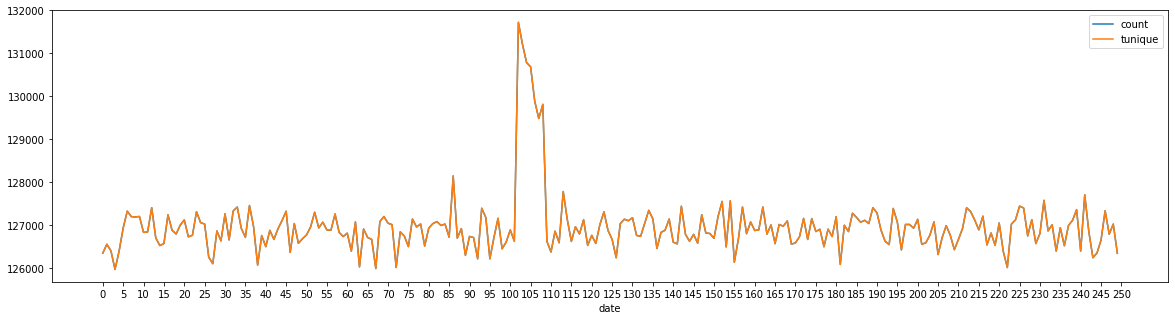

In [15]:
_ = receipts_date_agg_df['customer_id'].plot.line(figsize=(20, 5))
_ = plt.xticks(np.arange(0, 249 + 5, 5))

Можно заметить:
- клиенты совешают только одну покупку в день;
- в период компании кол-во покупок/клиентов увеличилось на ~5 тыс., а остальные дни в среднем составляет 127 тыс.

Посмотрим на этих новых клиентов

In [32]:
camp_ids = set(receipts_dd[(receipts_dd['date'] >= 102) & (receipts_dd['date'] < 102 + 7)]['customer_id'].values.compute())
other_ids = set(receipts_dd[receipts_dd['date'] < 102]['customer_id'].values.compute())

In [34]:
new_ids = list(camp_ids - other_ids)
len(new_ids)

8730

Посмотрим на среднее кол-во купленного фисштеха (в граммах)

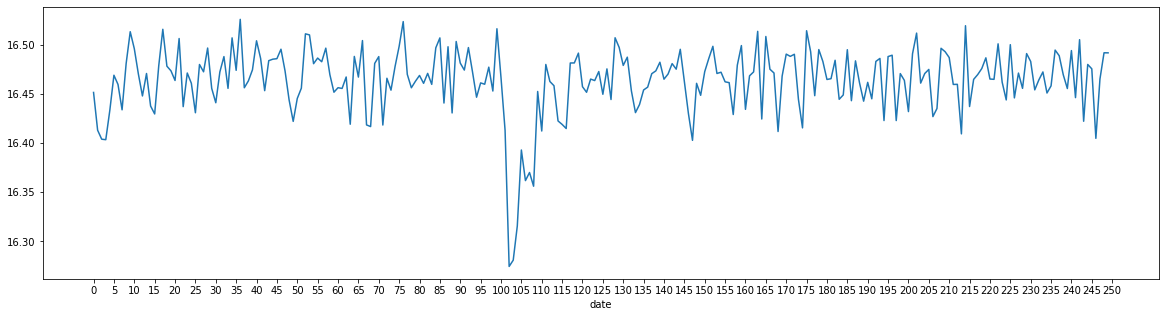

In [16]:
_ = receipts_date_agg_df['purchase_amt']['mean'].plot.line(figsize=(20, 5))
_ = plt.xticks(np.arange(0, 249 + 5, 5))

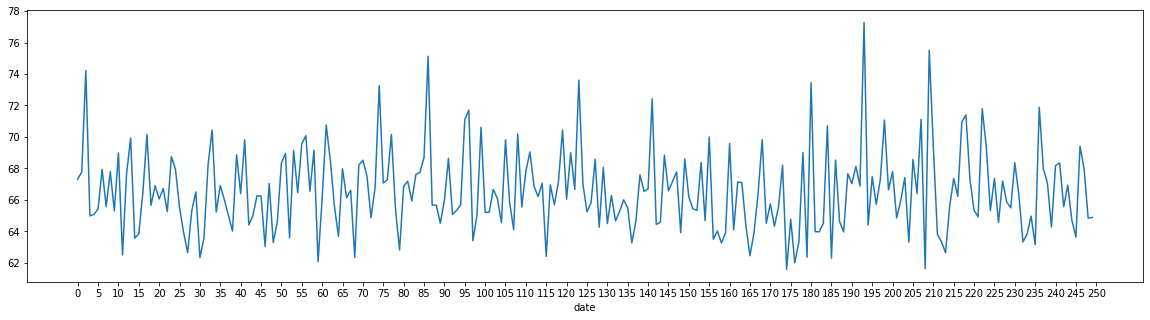

In [17]:
_ = receipts_date_agg_df['purchase_amt']['max'].plot.line(figsize=(20, 5))
_ = plt.xticks(np.arange(0, 249 + 5, 5))

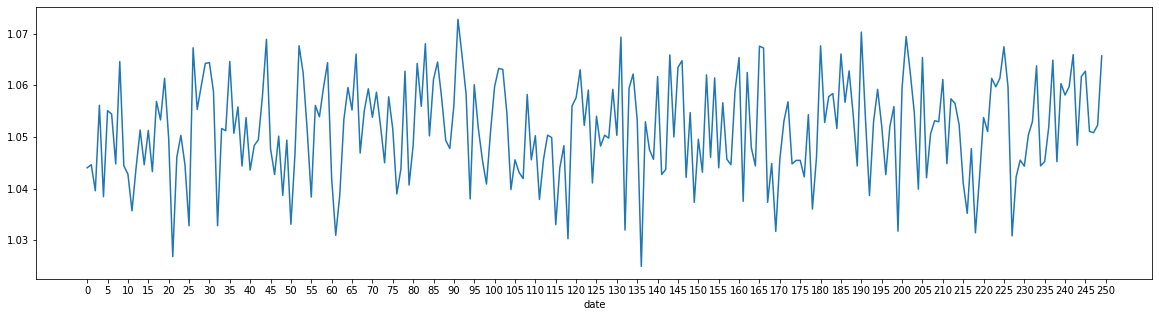

In [18]:
_ = receipts_date_agg_df['purchase_amt']['min'].plot.line(figsize=(20, 5))
_ = plt.xticks(np.arange(0, 249 + 5, 5))

Можно заметить, что обычно среднее кол-во составляет ~16,47 грамм, а дни компании оно уменьшилось до 16,3.

Посмотрим на сумму покупки

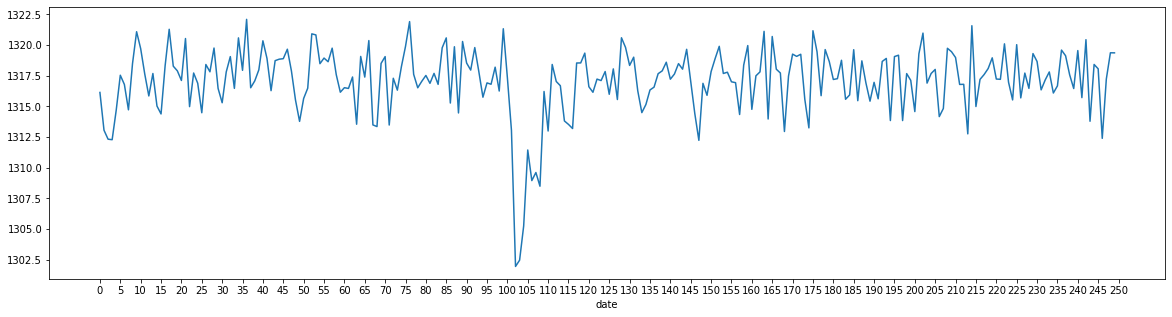

In [19]:
_ = receipts_date_agg_df['purchase_sum']['mean'].plot.line(figsize=(20, 5))
_ = plt.xticks(np.arange(0, 249 + 5, 5))

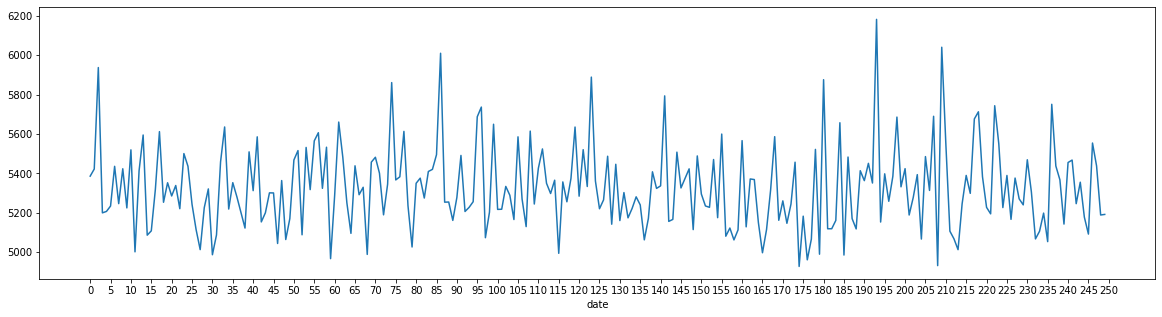

In [20]:
_ = receipts_date_agg_df['purchase_sum']['max'].plot.line(figsize=(20, 5))
_ = plt.xticks(np.arange(0, 249 + 5, 5))

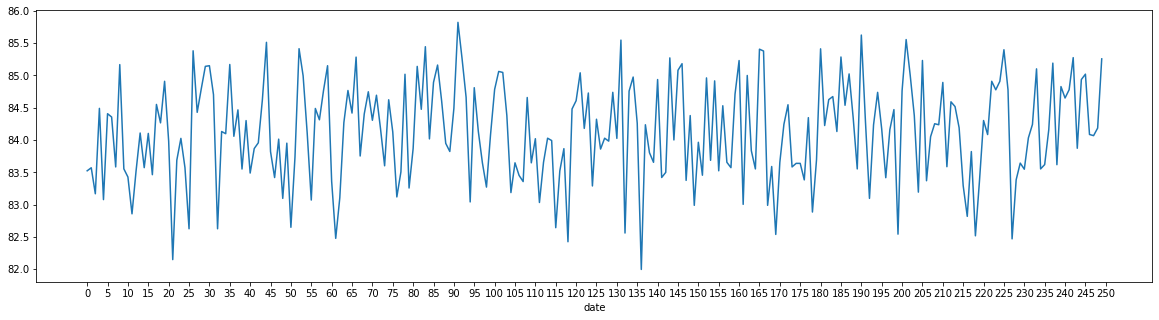

In [21]:
_ = receipts_date_agg_df['purchase_sum']['min'].plot.line(figsize=(20, 5))
_ = plt.xticks(np.arange(0, 249 + 5, 5))

Можно заметить, что обычно средняя сумма покупок составляет ~1317,5, а дни компании оно уменьшилась до 1302,5.

Посмотрим включается ли скидка в сумму покупки

In [22]:
receipts_dd[receipts_dd['discount'] == 0].compute().head()

,customer_id,date,purchase_amt,discount,purchase_sum
26,26,0,12.125273,0,970.021866
53,53,0,34.357035,0,2748.562788
56,56,0,8.695825,0,695.666022
58,58,0,28.299046,0,2263.923641
64,64,0,32.547511,0,2603.800857


In [23]:
80 * 12.125273

970.02184

In [24]:
receipts_dd[receipts_dd['discount'] != 0].compute().head()

,customer_id,date,purchase_amt,discount,purchase_sum
12,12,102,14.351911,40,1148.152907
19,19,102,3.840616,40,307.249242
39,39,102,12.696186,40,1015.694904
72,72,102,24.732437,40,1978.594946
86,86,102,16.100635,40,1288.050801


In [25]:
80 * 3.840616

307.24928

Нет, скидка не включена в сумму покупки

Теперь посмотрим на Uplift

In [26]:
receipts_flt_dd = receipts_dd[(receipts_dd['date'] >= 102) & (receipts_dd['date'] < 102 + 7)]
receipts_agg_dd = receipts_flt_dd.groupby('customer_id')[['purchase_amt', 'discount']].sum()
receipts_agg_dd.describe().compute()

,purchase_amt,discount
count,833269.000000,833269.000000
mean,17.910159,10.874039
std,9.405506,17.796551
min,1.043139,0.000000
25%,10.884846,0.000000
50%,16.312578,0.000000
75%,23.585634,40.000000
max,70.182055,40.000000


In [27]:
uplift_dd = (customers_dd[['customer_id']]
             .merge(receipts_agg_dd, how='left', on='customer_id')
             .merge(campaigns_dd[['customer_id', 'target_group_flag']], how='left', on='customer_id')
             .fillna(0))
uplift_dd['uplift'] = (28 * uplift_dd['purchase_amt'] 
                       - uplift_dd['target_group_flag']
                       - (uplift_dd['purchase_amt'] > 0).astype(int) * uplift_dd['discount'])
uplift_dd.describe().compute()

,customer_id,purchase_amt,discount,target_group_flag,uplift
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,9.999995e+05,7.461990e+00,4.530500e+00,2.500000e-01,2.041552e+02
std,5.773504e+05,1.071546e+01,1.267654e+01,4.330128e-01,2.960378e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.179211e+01
25%,3.016750e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.050250e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.405026e+06,1.422762e+01,0.000000e+00,0.000000e+00,3.873036e+02
max,1.999999e+06,7.018206e+01,4.000000e+01,1.000000e+00,1.965098e+03


In [28]:
uplift_df = uplift_dd.compute()

In [29]:
bins = pd.qcut(uplift_df['uplift'], 10, duplicates='drop')
uplift_df.groupby(bins).agg({'target_group_flag': ['mean', 'count']})

target_group_flag        
                                 mean   count
uplift                                       
(-11.793, -1.0]              1.000000  274443
(-1.0, 0.0]                  0.000111  893355
(0.0, 113.178]               0.462828   32202
(113.178, 311.63]            0.317330  200000
(311.63, 459.55]             0.259810  200000
(459.55, 660.947]            0.244295  200000
(660.947, 1965.098]          0.231335  200000

In [35]:
uplift_df[uplift_df['customer_id'].isin(new_ids)].describe()

,customer_id,purchase_amt,discount,target_group_flag,uplift
count,8.730000e+03,8730.000000,8730.000000,8730.000000,8730.000000
mean,9.303882e+05,19.732458,12.925544,0.323139,539.260151
std,5.942636e+05,10.243204,18.708078,0.467702,288.790120
min,1.350000e+02,1.087304,0.000000,0.000000,-10.555489
25%,3.912168e+05,12.032344,0.000000,0.000000,324.847550
50%,8.925280e+05,18.422154,0.000000,0.000000,502.402597
75%,1.453231e+06,26.356293,40.000000,1.000000,727.903509
max,1.999893e+06,63.988382,40.000000,1.000000,1750.674688


In [36]:
uplift_df[~uplift_df['customer_id'].isin(new_ids)].describe()

,customer_id,purchase_amt,discount,target_group_flag,uplift
count,1.991270e+06,1.991270e+06,1.991270e+06,1.991270e+06,1.991270e+06
mean,1.000305e+06,7.408195e+00,4.493695e+00,2.496794e-01,2.026861e+02
std,5.772568e+05,1.068651e+01,1.263149e+01,4.328275e-01,2.952330e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.179211e+01
25%,5.006412e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000414e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.500187e+06,1.397725e+01,0.000000e+00,0.000000e+00,3.805033e+02
max,1.999999e+06,7.018206e+01,4.000000e+01,1.000000e+00,1.965098e+03
